# 6 Partial Least Squares Regression

## Aim
Modeling and mapping continuous biophysical variables based on spectral data

## Loading and preparing the data

Index(['lai', 'x', 'y'], dtype='object')
(244, 500, 500)


(-0.5, 499.5, 499.5, -0.5)

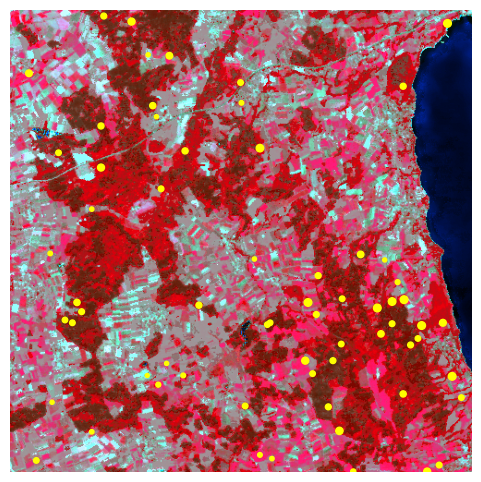

In [1]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = "C:/Users/louis/Desktop\Hyperspectral Remote Sensing/Sheet06/data"

image_path = f"{path}/enmap_ammersee.tif"

image = rasterio.open(image_path)
image_data = image.read()
transform = image.transform

calpoints = pd.read_csv(f"{path}/calpoints.txt", header=0, decimal=".", sep=" ")
valpoints = pd.read_csv(f"{path}/valpoints.txt", header=0, decimal=".", sep=" ")
LAI = np.array(calpoints["lai"])

print(calpoints.columns)
print(image_data.shape)

def coord_to_pixel(x, y, transform):
    col, row = ~transform * (x, y)
    return int(col), int(row)

calpoints['pixel_col'], calpoints['pixel_row'] = zip(*calpoints.apply(lambda row: coord_to_pixel(row['x'], row['y'], transform), axis=1))
valpoints['pixel_col'], valpoints['pixel_row'] = zip(*valpoints.apply(lambda row: coord_to_pixel(row['x'], row['y'], transform), axis=1))

# this replaces the stretch='lin'
def linear_stretch(band, lower_percent=2, upper_percent=98):
    
    lower = np.percentile(band, lower_percent)
    upper = np.percentile(band, upper_percent)    
    # Clip and scale
    stretched_band = np.clip(band, lower, upper)
    stretched_band = (stretched_band - lower) / (upper - lower)
    return stretched_band

band60 = linear_stretch(image_data[60])     
band45 = linear_stretch(image_data[45]) 
band30 = linear_stretch(image_data[30])  

rgb = np.dstack((band60, band45, band30))

fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(rgb)
point_sizes = LAI / 4 + 0.8
ax.scatter(calpoints['pixel_col'], calpoints['pixel_row'], 
           s=point_sizes * 10, facecolor='yellow')

plt.axis('off')


### Q6.1 (1 pt): 
Use your expert knowledge on visual image interpretation. Which vegetation type (deciduous
forest, needle leaf forest, grassland) features the highest LAI values?

**Answer:** (I used Google Earth to look up the vegetation types, as I cannot tell the difference between deciduous forest and needle leaf forest from the image alone.) On the left of the image is needle leaf forest with medium sized LAI dots, field/grassland dots are the smallest and LAI values on the right around the "Seeholz and Seewiese" nature reserve are the largest with deciduous forest vegetation type.

### Q6.2 (3 pts): 
PLSR model optimization is known to be affected by a skewed distribution of the response
variable. How are the LAI values statistically distributed? Perform a test, visualization or suitable
quantification to assess whether you are going to face problems (or have to think about some kind of
transformation)

**Answer:** The distribution has multiple peaks (multimodal distribution) and asymmetric, irregular shape. I think I will face problems; no transformation essentially unskewed it (I also tried Boxcox and Yeo-Johnson). Cross validating with LogLAI gave the best RMSE, so I will stick with that.

Shapiro-Wilk test - p-value: 0.001007826765999198


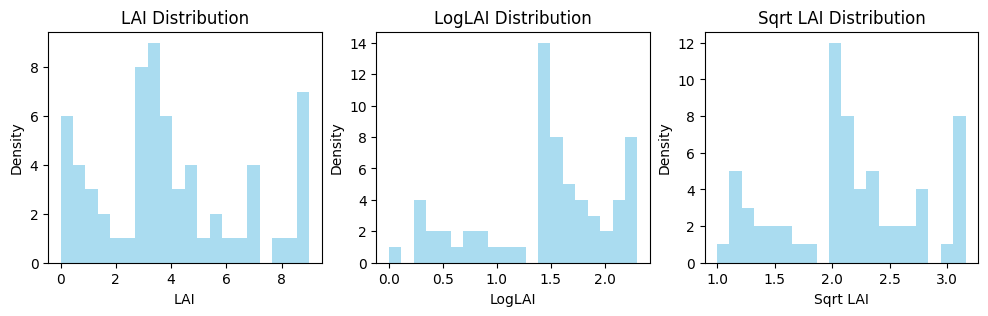

In [2]:
from scipy.stats import shapiro

# If the p-value ≤ 0.05, it indicates that the data significantly deviates from a normal distribution
statistic, p_value = shapiro(LAI)
print(f"Shapiro-Wilk test - p-value: {p_value}")

log_LAI = np.log(LAI + 1)
sqrt_LAI = np.sqrt(LAI + 1)

plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.hist(LAI, bins=20, color='skyblue', alpha=0.7)
plt.title("LAI Distribution")
plt.xlabel("LAI")
plt.ylabel("Density")

plt.subplot(1, 3, 2)
plt.hist(log_LAI, bins=20, color='skyblue', alpha=0.7)
plt.title("LogLAI Distribution")
plt.xlabel("LogLAI")
plt.ylabel("Density")

plt.subplot(1, 3, 3)
plt.hist(sqrt_LAI, bins=20, color='skyblue', alpha=0.7)
plt.title("Sqrt LAI Distribution")
plt.xlabel("Sqrt LAI")
plt.ylabel("Density")
plt.show()

### Q6.3 (1 pt): 
Take a look at the wavelength information. Is there anything strange about it (Of course, there is.
But what?)

**Answer:** There is a discontinuity from band 89 to 90 where it drops back in wavelength. This could have several causes (e.g. artifacts of the simulated data), but there are no duplicates in the wavelength, so I won't edit anything.

True


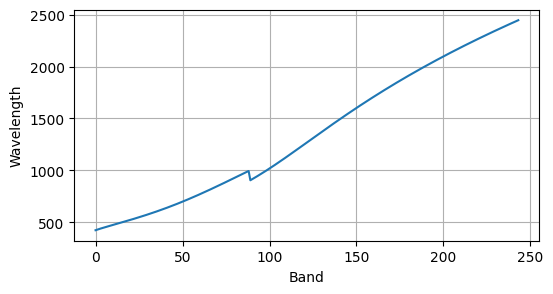

In [3]:
wl = pd.read_csv(f"{path}/enmap_wl.txt", names=["band", "wavelength"], decimal=".", sep=" ")
wavelengths = list(wl['wavelength'])
print(len(wavelengths) == len(set(wavelengths))) # duplicate test
wavelengths = np.array(wavelengths)

plt.figure(figsize=(6, 3))
plt.plot(wl.index, wavelengths)
plt.xlabel("Band")
plt.ylabel("Wavelength")
plt.grid()
plt.show()

## Extracting the calibration spectra

65
(65, 244)


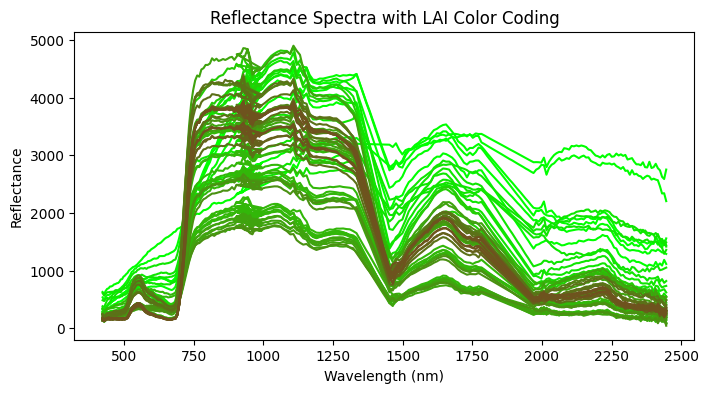

In [4]:
image_shape = image_data.shape[1] # 500x500

def extract(points, img_data):
    ref = []
    for _, row in points.iterrows():
        col, row = int(row['pixel_col']), int(row['pixel_row'])
        if 0 <= col < image_shape and 0 <= row < image_shape:
            ref.append(img_data[:, row, col])

    return np.array(ref)

calref = extract(calpoints, image_data)
print(calpoints.shape[0])
print(calref.shape)

# https://gka.github.io/palettes/#/11|s|784421,008000,00ff00|ffffe0,ff005e,93003a|0|1
# lime lowest LAI, brown highest LAI
gc = list(reversed(['#784421', '#6e531e', '#65611b', '#5c7018', '#548015', '#4a9112', '#3fa30e', '#32b709', '#23cd05', '#0fe501', '#00ff00']))

plt.figure(figsize=(8, 4))
for i in range(len(LAI)):
    plt.plot(wavelengths, calref[i, :], color=gc[int(round(LAI[i]))])

plt.title("Reflectance Spectra with LAI Color Coding")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.show()

### Q6.4 (1 pt): 
According to your visual examination in which spectral regions is the LAI value related to the
reflectance?

**Answer:** Definitely in the visible range 420-700nm, where LAI is indirectly proportional to reflectance. For the other regions it is harder to say; in the lower NIR higher LAI values have higher reflectance, but are also topped by lime lines (lower LAI values); from 1400nm to 2400nm it seems to be indirectly proportional again, but not so clear, with the brown values not quite at the bottom.

## Building a first PLSR model

### Q6.5 (1 pt): 
Which cross validation methods are available for plsr() or the plsr implementation you are using?

**Answer:** Sklearn offers different options for crossvalidation
Including the common: K-Fold Cross-Validation, Repeated K-Fold Cross-Validation, Leave-One-Out Cross-Validation (and even more e.g. Stratified K-Fold)

`from sklearn.model_selection import cross_val_predict, LeaveOneOut, KFold, RepeatedKFold`

### Q6.6 (1 pt): 
What happens if we refrain from standardizing the bands? Which bands would automatically get
a higher importance in the model?

**Answer:** Bands with more variance (e.g. in the lower NIR) would automatically get a higher importance in the model because they contribute more to the total variance and therefore more to the latent components. Even though they may not be as relevant for regressing LAI.

Best number of latent vectors: 11 RMSE: 1.2871006088977182
Best number of latent vectors for LogLAI: 9 RMSE: 0.8409895067535624
Best number of latent vectors for SqrtLAI: 11 RMSE: 0.9098265464668165


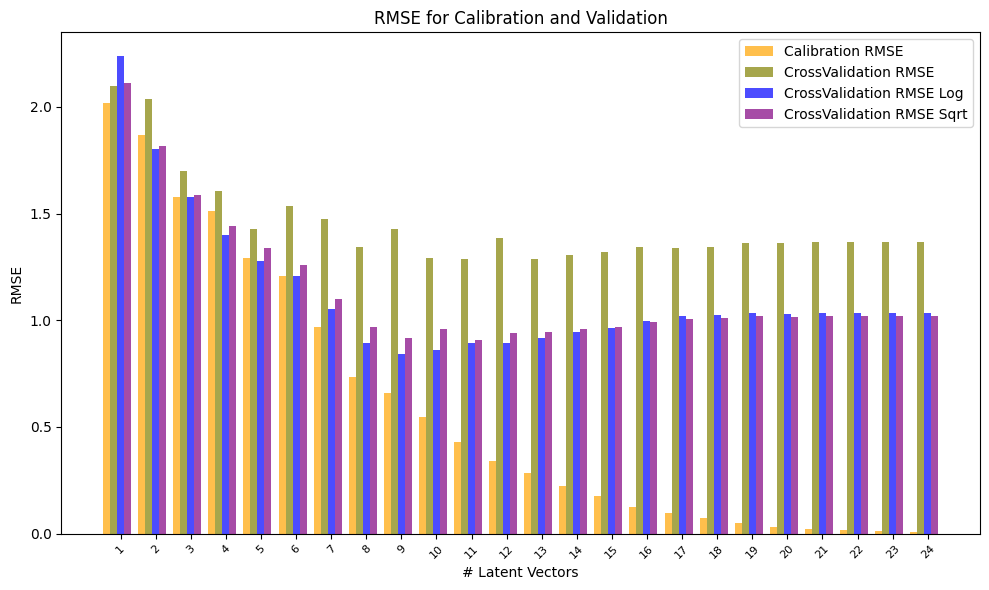

In [5]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, LeaveOneOut, cross_val_predict
from sklearn.metrics import mean_squared_error

X = calref
y = LAI

kf = KFold(n_splits=10, shuffle=True, random_state=42)

rmse_cal = []
rmse_val = []
rmse_val_log = []
rmse_val_sqrt = []

for n_comp in range(1, 25):
    pls = PLSRegression(n_components=n_comp, scale=True)
    pls_log = PLSRegression(n_components=n_comp, scale=True)
    pls_sqrt = PLSRegression(n_components=n_comp, scale=True)

    pls.fit(X, y)
    pls_log.fit(X, log_LAI)
    pls_sqrt.fit(X, sqrt_LAI)

    y_cal_pred = pls.predict(X)
    rmse_cal.append(np.sqrt(mean_squared_error(y, y_cal_pred)))
    
    y_val_pred = cross_val_predict(pls, X, y, cv=kf)
    rmse_val.append(np.sqrt(mean_squared_error(y, y_val_pred)))

    y_val_pred_log = cross_val_predict(pls_log, X, log_LAI, cv=kf)
    rmse_val_log.append(np.sqrt(mean_squared_error(y, np.exp(y_val_pred_log) - 1))) # backtransform; otherwise rmse is lower because of the lower scale

    y_val_pred_sqrt = cross_val_predict(pls_sqrt, X, sqrt_LAI, cv=kf)
    rmse_val_sqrt.append(np.sqrt(mean_squared_error(y, y_val_pred_sqrt**2 - 1))) # backtransform


nlv = np.argmin(rmse_val) + 1
nlv_log = np.argmin(rmse_val_log) + 1
nlv_sqrt = np.argmin(rmse_val_sqrt) + 1
print("Best number of latent vectors:", nlv, "RMSE:", rmse_val[nlv-1])
print("Best number of latent vectors for LogLAI:", nlv_log, "RMSE:", rmse_val_log[nlv_log-1])
print("Best number of latent vectors for SqrtLAI:", nlv_sqrt, "RMSE:", rmse_val_sqrt[nlv_sqrt-1])
latent_vectors = np.arange(1, len(rmse_val) + 1)

plt.figure(figsize=(10, 6))
width = 0.2

plt.bar(latent_vectors - 2 * width, rmse_cal, width=width, color='orange', label='Calibration RMSE', alpha=0.7)
plt.bar(latent_vectors - width, rmse_val, width=width, color='olive', label='CrossValidation RMSE', alpha=0.7)
plt.bar(latent_vectors, rmse_val_log, width=width, color='blue', label='CrossValidation RMSE Log', alpha=0.7)
plt.bar(latent_vectors + width, rmse_val_sqrt, width=width, color='purple', label='CrossValidation RMSE Sqrt', alpha=0.7)

plt.xlabel('# Latent Vectors')
plt.ylabel('RMSE')
plt.xticks(latent_vectors, fontsize=8, rotation=45)
plt.legend(loc='upper right')
plt.title('RMSE for Calibration and Validation')
plt.tight_layout()
plt.show()

### Q6.7 (2 pts): 
Why is the RMSE in calibration (displayed in orange) decreasing monotonically while the RMSE in
validation (olive) shows a more complex behavior? Which number of LVs leads to the smallest RMSE in
cross validation?

**Answer:** More latent vectors make the model more flexible and it can better fit the training data, but it is likely to overfit and fail to generalize to validation or test data. This can also be seen in the plot, where the validation performance initially decreases with the number of LVs, but after about ten LVs, the validation performance actually increases slightly instead of decreasing further, because the model is overfitting here. 

```
Best number of latent vectors: 11 RMSE: 1.287
Best number of latent vectors for LogLAI: 9 RMSE: 0.841
Best number of latent vectors for SqrtLAI: 11 RMSE: 0.910
```

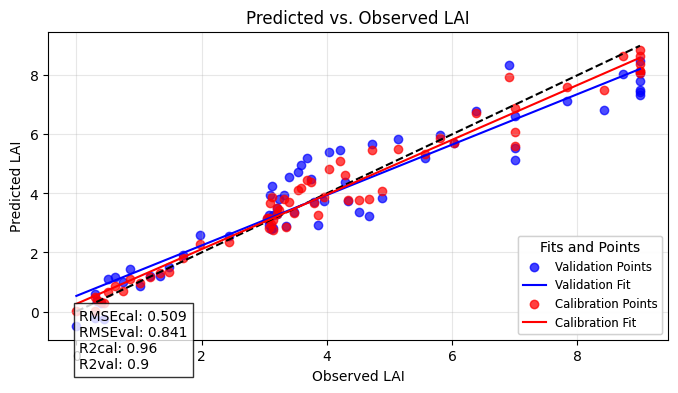

In [6]:
from sklearn.metrics import r2_score

# choose best transform (log)
y_observed = LAI
y = log_LAI
nlv = nlv_log
plsmod = PLSRegression(n_components=nlv, scale=True)
plsmod.fit(X, y)

y_cal = plsmod.predict(X)
y_cv = cross_val_predict(plsmod, X, y, cv=kf)
y_cal_predict = np.exp(y_cal) - 1
y_cv_predict = np.exp(y_cv) - 1

def regression_plot(y_cal_pr, y_cv_pr):
    
    rmse_val = np.sqrt(mean_squared_error(y_observed, y_cv_pr))
    rmse_cal = np.sqrt(mean_squared_error(y_observed, y_cal_pr))
    r2_val = r2_score(y_observed, y_cv_pr)
    r2_cal = r2_score(y_observed, y_cal_pr)

    metrics = {
        "RMSEcal": round(rmse_cal, 3),
        "RMSEval": round(rmse_val, 3),
        "R2cal": round(r2_cal, 2),
        "R2val": round(r2_val, 2)
    }

    plt.figure(figsize=(8, 4))

    plt.scatter(y_observed, y_cv_pr, color='#0000FF', label='Validation Points', alpha=0.7)
    plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='black', linestyle='--') # f(x)=x

    val_fit = np.polyfit(y_observed, y_cv_pr, 1)
    plt.plot(y_observed, np.polyval(val_fit, y_observed), color='#0000FF', label='Validation Fit')

    plt.scatter(y_observed, y_cal_pr, color='#FF0000', label='Calibration Points', alpha=0.7)

    cal_fit = np.polyfit(y_observed, y_cal_pr, 1)
    plt.plot(y_observed, np.polyval(cal_fit, y_observed), color='#FF0000', label='Calibration Fit')

    metric_legend = [f"{key}: {value}" for key, value in metrics.items()]
    metric_text = "\n".join(metric_legend)

    main_legend = plt.legend(loc='lower right', fontsize='small', title="Fits and Points")
    plt.gca().add_artist(main_legend)

    # secondary legend
    plt.text(
        0.05, 0.1, metric_text, transform=plt.gca().transAxes, fontsize=10, 
        bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top'
    )

    plt.xlabel("Observed LAI")
    plt.ylabel("Predicted LAI")
    plt.title("Predicted vs. Observed LAI")
    plt.grid(alpha=0.3)
    plt.show()

regression_plot(y_cal_predict, y_cv_predict)


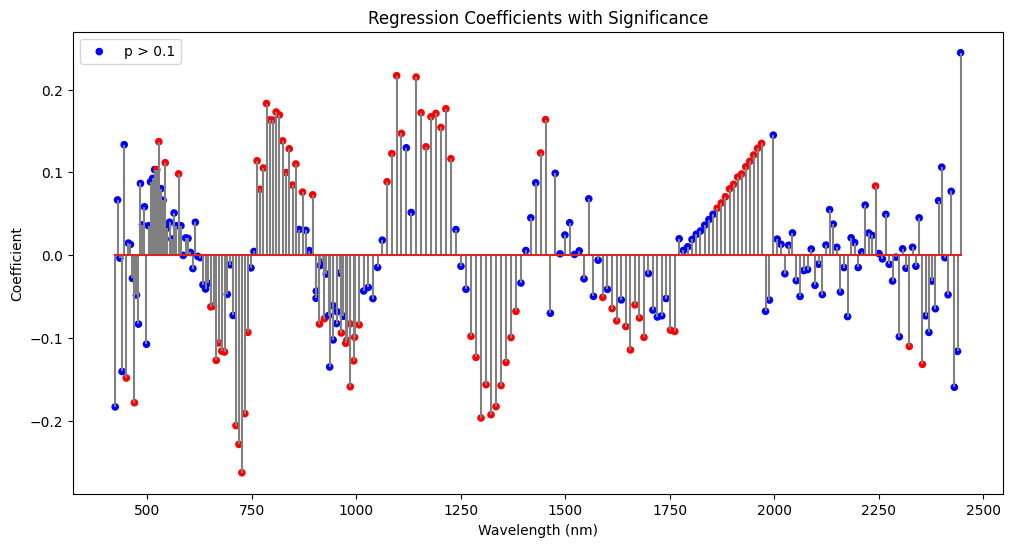

In [9]:
# I tried my best to copy the jack.test
import warnings
warnings.filterwarnings('ignore') # ignore future warnings
from scipy.stats import t

reg_coef = plsmod.coef_.flatten()
p = 0.1

n = plsmod.x_scores_.shape[0]
jackknife_coefs = np.zeros((n, reg_coef.shape[0]))

loo = LeaveOneOut()
for i, (train_idx, test_idx) in enumerate(loo.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = PLSRegression(n_components=nlv, scale=True)
    model.fit(X_train, y_train)
    jackknife_coefs[i] = model.coef_.flatten()

mean_coef = np.mean(jackknife_coefs, axis=0)
sum_sq = np.sum((jackknife_coefs - mean_coef)**2, axis=0)
var_jack = (n - 1) / n * sum_sq
std_err = np.sqrt(var_jack)

t_stat = mean_coef / std_err # jack.test has use.mean = TRUE as default if FALSE it would be  reg_coef / std_err
p_values = 2 * (1 - t.cdf(np.abs(t_stat), df=n-1))  # Two-tailed test

significant = p_values < p

# Plotting
plt.figure(figsize=(12, 6))
plt.stem(wavelengths, reg_coef, linefmt='grey', markerfmt=' ')
plt.scatter(wavelengths, reg_coef, c=['red' if s else 'blue' for s in significant], s=20)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Coefficient')
plt.title('Regression Coefficients with Significance')
plt.legend([f'p > {p}'], loc='upper left')
plt.show()

### Q6.8 (2 pts): 
Which spectral bands feature a high influence (i.e., a high absolute value of the regression
coefficient)? Is this selection in line with your visual interpretation of the spectra?

**Answer:** So I initially wrote that from 500 to 700 I see some indirect correlation, but here we have positive coefficients in these bands, indicating a positive correlation...

 The highest absolute values are actually around the red edge inflection point, which makes perfect sense for LAI (vegetation properties such as chlorophyll content); in the plot earlier, the spectra overlapped so much that I could not really tell from the image.

Other high absolute values are around 750-850, 1100-1200, 1300-1350 nm (lower NIR), which may correspond to other vegetation-related properties or water absorption features that may be relevant.

## Optimizing the model through backward selection of spectral bands

In [11]:
wavelengths2 = wavelengths[significant]
print(image_data.shape)

image_data2 = image_data[significant, :, :]
print(image_data2.shape)

calref2 = extract(calpoints, image_data2)

(244, 500, 500)
(91, 500, 500)


Best number of latent vectors: 8 RMSE: 1.2144328547916783
Best number of latent vectors Log: 9 RMSE: 0.703681586733841


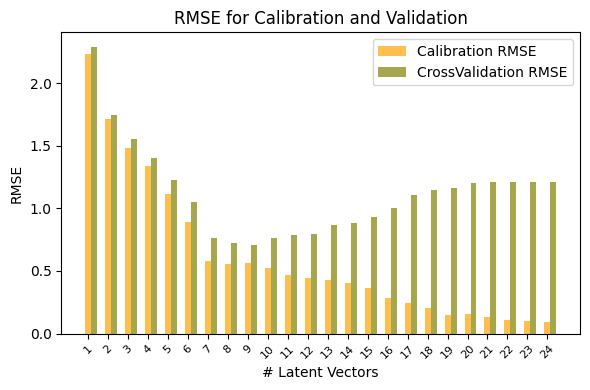

In [12]:
# we already know now that logLAI is the best transform

X = calref2
y = log_LAI

rmse_cal = []
rmse_val = []
rmse_val_normal = []

for n_comp in range(1, 25):
    pls = PLSRegression(n_components=n_comp, scale=True)
    pls.fit(X, y)
    pls_normal = PLSRegression(n_components=n_comp, scale=True)
    pls_normal.fit(X, LAI)

    y_cal_pred = pls.predict(X)
    rmse_cal.append(np.sqrt(mean_squared_error(y_observed, np.exp(y_cal_pred) - 1)))
    
    y_val_pred = cross_val_predict(pls, X, y, cv=kf)
    rmse_val.append(np.sqrt(mean_squared_error(y_observed, np.exp(y_val_pred) - 1)))

    y_val_normal_pred = cross_val_predict(pls_normal, X, LAI, cv=kf)
    rmse_val_normal.append(np.sqrt(mean_squared_error(y_observed, y_val_normal_pred)))

nlv_normal = np.argmin(rmse_val_normal) + 1
nlv = np.argmin(rmse_val) + 1
print("Best number of latent vectors:", nlv_normal, "RMSE:", rmse_val_normal[nlv_normal-1])
print("Best number of latent vectors Log:", nlv, "RMSE:", rmse_val[nlv-1])
latent_vectors = np.arange(1, len(rmse_val) + 1)

plt.figure(figsize=(6, 4))
width = 0.3

plt.bar(latent_vectors, rmse_cal, width=width, color='orange', label='Calibration RMSE', alpha=0.7)
plt.bar(latent_vectors + width, rmse_val, width=width, color='olive', label='CrossValidation RMSE', alpha=0.7)

plt.xlabel('# Latent Vectors')
plt.ylabel('RMSE')
plt.xticks(latent_vectors, fontsize=8, rotation=45)
plt.legend(loc='upper right')
plt.title('RMSE for Calibration and Validation')
plt.tight_layout()
plt.show()

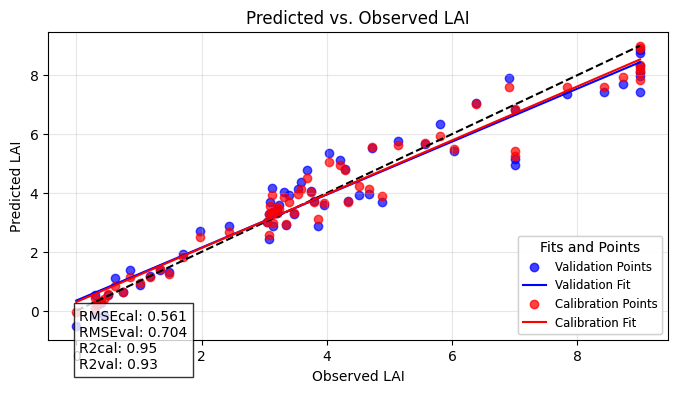

In [13]:
plsmod = PLSRegression(n_components=nlv, scale=True)
plsmod.fit(X, y)

y_cal = plsmod.predict(X)
y_cv = cross_val_predict(plsmod, X, y, cv=kf)
y_cal_predict = np.exp(y_cal) - 1
y_cv_predict = np.exp(y_cv) - 1

regression_plot(y_cal_predict, y_cv_predict)

### Q6.9 (1 pt): 
Compare the model fit to the results of the first model. How did RMSE and R2 change?

**Answer:** 
```
First Model:
    RMSEcal: 0.509
    RMSEval: 0.841
    R2cal: 0.96
    R2val: 0.9
```
```
Second Model:
    RMSEcal: 0.561
    RMSEval: 0.704
    R2cal: 0.95
    R2val: 0.93
```

Calibration RMSE and R2 worsened slightly because we have fewer bands/features to (over)fit; but validation correlation and RMSE improved, showing better generalization capabilities. Removing unnecessary bands really helped the overfitting by removing some noise in the data.

## Mapping the LAI distribution

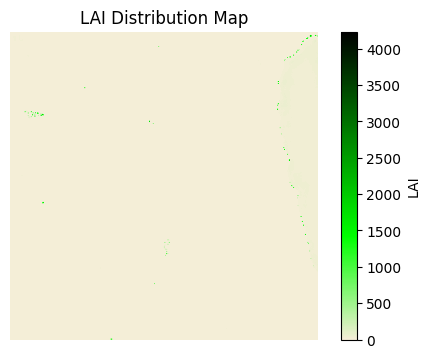

In [14]:
from matplotlib.colors import LinearSegmentedColormap

bands, height, width = image_data2.shape
pixval = image_data2.reshape(bands, -1).T  # Reshape to (num_pixels, num_bands)

mapvalues = np.exp(plsmod.predict(pixval).flatten()) - 1 # predict and backtransform does not work yet (only with masks); too high exponentials

lai_map = mapvalues.reshape(height, width)

colors = ["#F4EED7", "#00FF00", "#008000", "#000000"]
color_gradient = LinearSegmentedColormap.from_list("LAI_Gradient", colors, N=255)

plt.figure(figsize=(6, 4))
plt.imshow(lai_map, cmap=color_gradient)
plt.colorbar(label="LAI")
plt.axis("off")
plt.title("LAI Distribution Map")
plt.show()


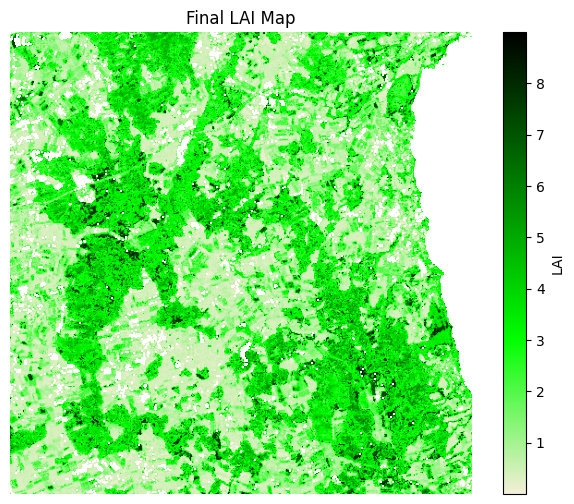

In [15]:
ref800 = image_data[64, :, :]
ref670 = image_data[46, :, :]

ndvi = (ref800 - ref670) / (ref800 + ref670)
ndvi_mask = np.where(ndvi > 0, 1, np.nan) 

lai_masked = lai_map * ndvi_mask
lai_final = np.where((lai_masked > 0) & (lai_masked <= 9), lai_masked, np.nan)

plt.figure(figsize=(8, 6))
plt.imshow(lai_final, cmap=color_gradient)
plt.colorbar(label="LAI")
plt.axis("off")
plt.title("Final LAI Map")
plt.show()


## Accuracy assessment

In [16]:
valref = []
y_predict = []
for _, row in valpoints.iterrows():
    col, row = int(row['pixel_col']), int(row['pixel_row'])
    if 0 <= col < image_shape and 0 <= row < image_shape:
        valref.append(image_data2[:, row, col])
        y_predict.append(lai_map[row, col])
        # y_predict.append(lai_final[row, col]) # throws Input contains NaN; so valpoints are actually also masked/cut off

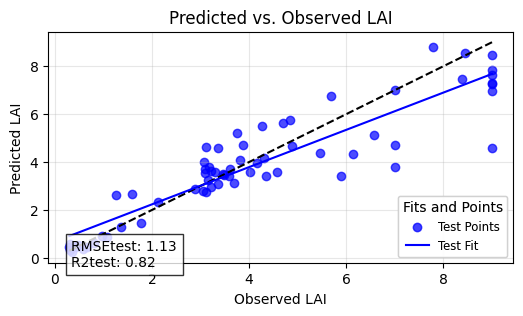

In [17]:
y_test = np.array(valpoints['lai'])

def regression_plot_test(y_pr):

    rmse_test = np.sqrt(mean_squared_error(y_test, y_pr))
    r2_test = r2_score(y_test, y_pr)
    metrics = {
        "RMSEtest": round(rmse_test, 2),
        "R2test": round(r2_test, 2),
    }

    plt.figure(figsize=(6, 3))

    plt.scatter(y_test, y_pr, color='#0000FF', label='Test Points', alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--')  # f(x)=x

    test_fit = np.polyfit(y_test, y_pr, 1)
    plt.plot(y_test, np.polyval(test_fit, y_test), color='#0000FF', label='Test Fit')

    metric_legend = [f"{key}: {value}" for key, value in metrics.items()]
    metric_text = "\n".join(metric_legend)

    main_legend = plt.legend(loc='lower right', fontsize='small', title="Fits and Points")
    plt.gca().add_artist(main_legend)

    # secondary legend
    plt.text(
        0.05, 0.1, metric_text, transform=plt.gca().transAxes, fontsize=10, 
        bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top'
    )

    plt.xlabel("Observed LAI")
    plt.ylabel("Predicted LAI")
    plt.title("Predicted vs. Observed LAI")
    plt.grid(alpha=0.3)
    plt.show()

regression_plot_test(y_predict)

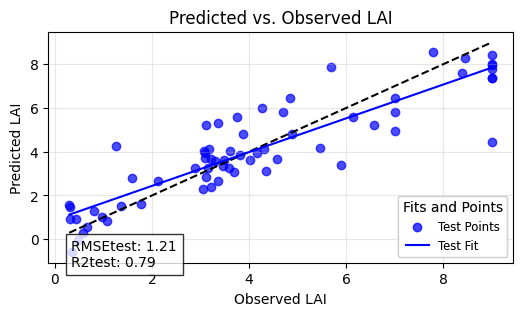

In [18]:
# I also want to see the prediction of the normal (not logged transform)
X = calref2
y = LAI
plsmod_normal = PLSRegression(n_components=nlv_normal, scale=True)
plsmod_normal.fit(X, y)

y_predict_normal = plsmod_normal.predict(valref)
regression_plot_test(y_predict_normal)

### Q6.10 (1 pts): 
Compare the R2 and RMSE of the independent validation to the reults of the cross validation.
Do they differ? If yes, can you guess why?

**Answer:** 
```
Second Model Validation/Testing:
    RMSEval: 0.704
    RMSEtest: 1.13
    R2val: 0.93
    R2test: 0.82
```

The test evaluation is actually much worse. As I noted earlier in the code, some validation points are actually masked, so they are outside the predicted LAI range. The exponential backtransform seems to intensify this, so I wanted to compare again with the normal (untransformed) data, but it performs even worse. These valpoints may have different characteristics/unseen conditions and this could lead to poorer generalization.

### Q6.11 (3 pts): 
Search the web for the 'ratio of performance to deviation (RPD)', a measure to interpret the
prediction ability of a model. Calculate the RPD for our second model. How do you judge the prediction
ability of your LAI model?

**Answer:**

> "It is the ratio between the standard deviation of a variable and the standard error of prediction of that variable by a given model. However, its systematic use has been criticized by several authors, since using the standard deviation to represent the spread of a variable can be misleading on skewed dataset."

-https://search.r-project.org/CRAN/refmans/yardstick/html/rpd.html

An RPD value greater than 2 typically indicates that the model has good predictive ability, while values below 1.5 suggest poor predictive performance.
The second model has an RPD of 2.33 so it has a good predictive ability, even for the testing dataset.

However, an RPD ≥ 2.5 indicates excellent model performance; reliable for accurate predictions.
Maybe we were screwed from the start because of the LAI distribution.


In [19]:
sd_observed = np.std(y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
rpd = sd_observed / rmse

print(f"Standard Deviation of Observed LAI: {sd_observed:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"RPD: {rpd:.2f}")

Standard Deviation of Observed LAI: 2.62
RMSE: 1.13
RPD: 2.33


### My Question

> "When the amount of SOC dropped below 1%, reflectance spectra
are not able to predict SOC contents, whatever the spectral resolution."

Is this just a limitation of their approach? Were there machine learning techniques available in 2007 that could have been better suited for predicting lower SOC contents? 
Additionally, could hybrid approaches, such as combining PLSR with other methods, have improved regression performance?

Or would it still be fundamentally limited by the weak spectral response of low SOC levels and the inherent noise?
